In [1]:
from Features.birds import *
from Features.sweden_map import *
from Features.weather import *
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from Features import df_functions


In [6]:
#API_tomorrow_weather(lon=lng, lat=lat, days=7)

## Bird data

What we want: 
lat, lon, num obs, time (maybe), obsReviewed

from api:


In [15]:
#1
def drop_unused_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols_keep = ["OBSERVATION COUNT", "LATITUDE", "LONGITUDE", "OBSERVATION DATE", "TIME OBSERVATIONS STARTED"]

    return df[cols_keep]

# new stuff, hope it not breaks! 
def patch_bird_data_holes(bird_df: pd.DataFrame, b_type: str) -> pd.DataFrame:
    daily_dict = API_bird_data(bird_type=b_type, backfill=True)
    daily_df = pd.DataFrame(daily_dict)

    daily_df.rename(columns={
        "obsDt": "OBSERVATION DATE",
        "lat": "LATITUDE",
        "lng": "LONGITUDE",
        "howMany": "OBSERVATION COUNT"
    }, inplace=True)

    drop_cols = ["speciesCode","comName","sciName","locId","locName",
                 "obsValid","obsReviewed","locationPrivate","subId"]
    daily_df.drop(columns=[c for c in drop_cols if c in daily_df.columns], inplace=True)

    ret_df = pd.concat([bird_df, daily_df], ignore_index=True)
    return ret_df


def fill_na_times(df: pd.DataFrame) -> pd.DataFrame:
    times = pd.to_datetime(df['TIME OBSERVATIONS STARTED'], format='%H:%M:%S', errors='coerce')

    # Calculate mean, round to nearest Hour ('H'), extract time
    mean_time = times.mean().round('h').time()
    df = df.fillna({"TIME OBSERVATIONS STARTED": mean_time})
    return df

def sort_bird_df_date_time(df:pd.DataFrame) -> pd.DataFrame:
    #df['TIME OBSERVATIONS STARTED'] = pd.to_datetime(df['TIME OBSERVATIONS STARTED'], format='%H:%M:%S', errors='coerce')
    df.sort_values(by=['OBSERVATION DATE', 'TIME OBSERVATIONS STARTED'], inplace=True)
    return df

def filter_by_year(df: pd.DataFrame, year: int = 2011) -> pd.DataFrame:
    df['OBSERVATION DATE'] = pd.to_datetime(df['OBSERVATION DATE'])
    return df[df['OBSERVATION DATE'].dt.year >= year]

def daily_bird_call(today:str, b_type:str) -> pd.DataFrame:
    daily_dict=API_bird_data(bird_type=b_type)
    daily_df = pd.DataFrame(daily_dict)
   
    daily_df.rename(columns={"obsDt":"OBSERVATION DATE", "lat": "LATITUDE", "lng": "LONGITUDE", "howMany": "OBSERVATION COUNT"}, inplace=True)
    daily_df.drop(columns=["speciesCode","comName", "sciName", "locId", "locName", "obsValid", "obsReviewed", "locationPrivate", "subId"], inplace=True) # what is the howMany column
    
    dt = pd.to_datetime(daily_df["OBSERVATION DATE"], errors="coerce", format="mixed")
    daily_df = daily_df.loc[~dt.isna()].copy()
    daily_df["OBSERVATION DATE"] = dt.dt.strftime("%Y-%m-%d")
    daily_df["TIME OBSERVATIONS STARTED"] = dt.dt.strftime("%H:%M:%S")
# filter by day; 
    daily_df = daily_df[daily_df['OBSERVATION DATE'] == today]
    
    # if it is empty, return empty df with cols: ["OBSERVATION COUNT", "LATITUDE", "LONGITUDE", "OBSERVATION DATE", "TIME OBSERVATIONS STARTED"]
    if daily_df.empty:
        daily_df = pd.DataFrame(columns=["OBSERVATION COUNT", "LATITUDE", "LONGITUDE", "OBSERVATION DATE", "TIME OBSERVATIONS STARTED"])
    return daily_df # need a standard thing to return if empty

def map_bird_region(df: pd.DataFrame) -> pd.DataFrame:
    map=SwedenMap()
    regions = []
    for index, row in df.iterrows():
        lat = row['LATITUDE']
        lng = row['LONGITUDE']
        region = map.point_to_region(lon=lng,lat=lat)
        regions.append(region)
    df['REGION'] = regions
    return df


def merge_weather_data(bird_df: pd.DataFrame, weather_df: pd.DataFrame) -> pd.DataFrame:
    # 1. Pivot weather_df so variables (Temp, Rain, etc.) become columns
    # Assumes 'daily' column contains actual lists. If strings, use ast.literal_eval first.
    weather_pivoted = weather_df.pivot(index='REGION', columns='daily_units', values='daily')

    # 2. Explode the lists into individual rows (pandas >= 1.3.0)
    weather_exploded = weather_pivoted.explode(list(weather_pivoted.columns))

    # 3. Rename columns to match requirements
    weather_exploded.rename(columns={
        'iso8601': 'OBSERVATION DATE',
        '°C': 'TEMPERATURE',
        'mm': 'RAIN',
        'km/h': 'WIND',
        'wmo code': 'WEATHERCODE'
    }, inplace=True)
    
    # 4. Reset index to turn REGION back into a column
    weather_exploded.reset_index(inplace=True)

    # 5. Ensure date formats match for merging
    bird_df['OBSERVATION DATE'] = bird_df['OBSERVATION DATE'].astype(str)
    weather_exploded['OBSERVATION DATE'] = weather_exploded['OBSERVATION DATE'].astype(str)

    # 6. Merge left to keep all bird observations
    merged_df = pd.merge(bird_df, weather_exploded, on=['REGION', 'OBSERVATION DATE'], how='right')

    return merged_df


def add_weather_to_bird(today: str, bird_df: pd.DataFrame) -> pd.DataFrame:
    map=SwedenMap()
    weather_df = pd.DataFrame()
    for key, (lat, lng) in map.centroid_dict.items():
        weather_dict, COLS = historical_weather_download(start_date=today, lon=lng, lat=lat)
        temp_weather_df = pd.DataFrame(weather_dict)
        temp_weather_df["REGION"] = key
        weather_df = pd.concat([weather_df, temp_weather_df], ignore_index=True)
    
    # we have COLS = ["OBSERVATION DATE", "TEMPERATURE", "RAIN", "WIND", "WEATHERCODE"]
    # from the dataframe, the daily col needs to be exploaded into separate columns with the same index
    
    merged_df = merge_weather_data(bird_df, weather_df)
    return merged_df

def add_normalized_year(df: pd.DataFrame, start_year: int = 2011) -> pd.DataFrame:
    df['OBSERVATION DATE'] = pd.to_datetime(df['OBSERVATION DATE'])
    df['YEAR'] = df['OBSERVATION DATE'].dt.year - start_year
    return df

def one_hot_months(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['MONTH'] = pd.to_datetime(df['OBSERVATION DATE']).dt.month
    month_dummies = pd.get_dummies(df['MONTH'], prefix='MONTH')
    all_months = [f"MONTH_{m}" for m in range(1, 13)] # Force all months 1–12 to exist
    month_dummies = month_dummies.reindex(columns=all_months, fill_value=False)
    df = pd.concat([df, month_dummies], axis=1)
    df.drop(columns=['MONTH'], inplace=True)
    return df

def clean_bird_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) Normalize counts
    df['OBSERVATION COUNT'] = (
        df['OBSERVATION COUNT']
        .replace('X', 1)
        .fillna(0)
        .astype(int)
    )
    df['OBSERVATION DATE'] = df['OBSERVATION DATE'].astype(str)

    # 2) Index of row to KEEP (max count per REGION + DATE)
    idx = (
        df.groupby(['REGION', 'OBSERVATION DATE'])['OBSERVATION COUNT']
        .idxmax()
    )

    # 3) Take those rows → keeps ALL original columns
    result = df.loc[idx].copy()

    # 4) Compute summed counts
    summed_counts = (
        df.groupby(['REGION', 'OBSERVATION DATE'])['OBSERVATION COUNT']
        .sum()
        .values
    )

    # 5) Overwrite count column
    result['OBSERVATION COUNT'] = summed_counts

    return result.reset_index(drop=True)


def backfill_weather(start_date: str) -> pd.DataFrame:
    map = SwedenMap()
    region_dict = map.centroid_dict
    region_df = pd.DataFrame(region_dict.items(), columns=['REGION', 'COORDINATES']) #lat, lon
    full_df = pd.DataFrame()
    for reg, coord in region_df.iterrows():
        data, labels = historical_weather_download(start_date=start_date, lon=coord["COORDINATES"][1], lat=coord["COORDINATES"][0])
        df_temp = pd.DataFrame(data=data)
        df_temp["REGION"] = coord["REGION"]
        weather_pivoted = df_temp.pivot(index='REGION', columns='daily_units', values='daily')
        weather_exploded = weather_pivoted.explode(list(weather_pivoted.columns))

        # 3. Rename columns to match requirements
        weather_exploded.rename(columns={
            'iso8601': 'OBSERVATION DATE',
            '°C': 'TEMPERATURE',
            'mm': 'RAIN',
            'km/h': 'WIND',
            'wmo code': 'WEATHERCODE'
        }, inplace=True)
        
        # 4. Reset index to turn REGION back into a column
        weather_exploded.reset_index(inplace=True)
        weather_exploded['OBSERVATION DATE'] = weather_exploded['OBSERVATION DATE'].astype(str)
        full_df = pd.concat([full_df, weather_exploded], ignore_index=True)
    return full_df 

        
def merge_historic_weather(bird_df: pd.DataFrame, weather_df: pd.DataFrame) -> pd.DataFrame:
    bird_df = bird_df.copy()
    weather_df = weather_df.copy()
    bird_df['OBSERVATION DATE'] = ( pd.to_datetime(bird_df['OBSERVATION DATE']).dt.strftime('%Y-%m-%d'))
    weather_df['OBSERVATION DATE'] = weather_df['OBSERVATION DATE'].astype(str)
    
    # Weather defines the full (REGION, DATE) grid
    return weather_df.merge(
        bird_df,
        on=['REGION', 'OBSERVATION DATE'],
        how='left'
    )
def add_rolling_sight_features(df: pd.DataFrame, k: int = 3) -> pd.DataFrame:
    df = df.copy()

    # Ensure types
    df["OBSERVATION DATE"] = pd.to_datetime(df["OBSERVATION DATE"])

    # Sort so shifts are correct
    df = df.sort_values(["BIRD TYPE", "REGION", "OBSERVATION DATE"])

    # Binary sighted flag
    df["SIGHTED"] = (df["OBSERVATION COUNT"] > 0).astype(int)

    # Past k days as lag features
    g_sighted = df.groupby(["BIRD TYPE", "REGION"])["SIGHTED"]
    g_count = df.groupby(["BIRD TYPE", "REGION"])["OBSERVATION COUNT"]

    for i in range(1, k + 1):
        df[f"SIGHTED LAG_{i}"] = g_sighted.shift(i).fillna(0).astype(int)
        df[f"OBS_COUNT_LAG_{i}"] = g_count.shift(i).fillna(0).astype(int)

    return df

def historical():
    """
    Get the historical weather and bird obs to add to the Hopsworks dataframe
    """
    df_golden = pd.read_csv(
    'Data/ebd_SE_goleag_smp_relOct-2025_extracted/ebd_SE_goleag_smp_relOct-2025.txt', 
    sep='\t', 
    low_memory=False, # Prevents DtypeWarnings on mixed-type columns in large files
    parse_dates=['OBSERVATION DATE', 'LAST EDITED DATE'] # Optional: converts dates immediately
)

    df_whteag = pd.read_csv(
        "Data/ebd_SE_whteag_smp_relOct-2025_extracted/ebd_SE_whteag_smp_relOct-2025.txt",
        sep='\t', 
        low_memory=False, # Prevents DtypeWarnings on mixed-type columns in large files
        parse_dates=['OBSERVATION DATE', 'LAST EDITED DATE'] # Optional: converts dates immediately
    )
    birds = {"whteag": df_whteag,"goleag": df_golden}
    weather_historic = backfill_weather(start_date="2025-10-01")
    final_bird_dfs = pd.DataFrame()
    for name, df in birds.items():

        df_dropped = drop_unused_columns(df)
        
        df_patched_holes = patch_bird_data_holes(df_dropped, b_type=name)
        df_na_times_filled = fill_na_times(df_patched_holes)
        df_sorted_date = sort_bird_df_date_time(df_na_times_filled)
        df_filtered_year = filter_by_year(df_sorted_date, year=2011)
        df_mapped_region = map_bird_region(df_filtered_year)


        cleaned_bird = clean_bird_data(df_mapped_region)
        df_bird = merge_historic_weather(cleaned_bird, weather_historic)
        df_bird["BIRD TYPE"] = name
        

        # fill nan vals in obs to 0 
        df_bird['OBSERVATION COUNT'] = df_bird['OBSERVATION COUNT'].fillna(0).astype(int)
        df_norm_year = add_normalized_year(df_bird, start_year=2011)
        df_1h_months = one_hot_months(df_norm_year)
        df_1h_months['OBSERVATION DATE'] = ( pd.to_datetime(df_1h_months['OBSERVATION DATE']).dt.strftime('%Y-%m-%d'))

        final_bird_dfs = pd.concat([final_bird_dfs, df_1h_months], ignore_index=True)

    final_bird_dfs.drop(columns=["LATITUDE", "LONGITUDE"], inplace=True)
    final_bird_dfs.columns = final_bird_dfs.columns.str.replace(" ", "_")

    return final_bird_dfs


def daily():
    """
    Get the weather and bird obs to add to the Hopsworks dataframe
    """
    # Get today's date in 'YYYY-MM-DD' format
    #TODAY = datetime.now().strftime('%Y-%m-%d')
    TODAY = datetime.now(ZoneInfo("Europe/Stockholm")).date().isoformat()

    bird_types = ["whteag", "goleag"]
    reigon_dict = SwedenMap().centroid_dict
    weather_df = pd.DataFrame()
    # get wheather for today
    for name, (lat,lon) in reigon_dict.items():
        weather_dict, COLS = historical_weather_download(start_date=TODAY, lon=lon, lat=lat)
        temp_weather_df = pd.DataFrame(weather_dict)
        temp_weather_df["REGION"] = name
        temp_weather_df["OBSERVATION DATE"] = TODAY
        weather_df = pd.concat([weather_df, temp_weather_df], ignore_index=True)

    # for each bird type, get today's bird data
    ret_df = pd.DataFrame()

    for idx, b_type in enumerate(bird_types):
        today_bird = daily_bird_call(today=TODAY, b_type=b_type)
        
        if not today_bird.empty:
            today_bird_mapped = map_bird_region(today_bird)
            merged_df = merge_weather_data(today_bird_mapped, weather_df)
        else: 
            # create empty df with cols of merged df
            merged_df_emtpy = pd.DataFrame(columns=["OBSERVATION COUNT", "LATITUDE", "LONGITUDE", "OBSERVATION DATE", 
                    "TIME OBSERVATIONS STARTED", "REGION"])
            merged_df = merge_weather_data(merged_df_emtpy, weather_df)
        merged_df.drop(columns=["LATITUDE", "LONGITUDE"], inplace=True)
        merged_df['BIRD TYPE'] = b_type
        merged_df.fillna({"OBSERVATION COUNT": 0}, inplace=True)
        ret_df = pd.concat([ret_df, merged_df], ignore_index=True)
    
    # one hot and add norm year
    ret_df = add_normalized_year(ret_df, start_year=2011)
    ret_df = one_hot_months(ret_df)
    ret_df.columns = ret_df.columns.str.replace(" ", "_")

    
    return ret_df

def features(days: int = 7) -> pd.DataFrame:
    """
    Get the features for the model
    """
    TODAY = datetime.now().strftime('%Y-%m-%d')
    reigon_dict = SwedenMap().centroid_dict
    weather_df = pd.DataFrame()
    # get wheather for today
    ret_df = pd.DataFrame()
    for name, (lat,lon) in reigon_dict.items():
        weather_dict = API_tomorrow_weather(days=days, lon=lon, lat=lat)
        temp_weather_df = pd.DataFrame(weather_dict)
        temp_weather_df["REGION"] = name
        
        weather_pivoted = temp_weather_df.pivot(index='REGION', columns='daily_units', values='daily')
        weather_exploded = weather_pivoted.explode(list(weather_pivoted.columns))

        # 3. Rename columns to match requirements
        weather_exploded.rename(columns={
            'iso8601': 'OBSERVATION DATE',
            '°C': 'TEMPERATURE',
            'mm': 'RAIN',
            'km/h': 'WIND',
            'wmo code': 'WEATHERCODE'
        }, inplace=True)
        weather_exploded["REGION"] = name
        ret_df = pd.concat([ret_df, weather_exploded], ignore_index=True)

    one_h = one_hot_months(ret_df)
    final_df = add_normalized_year(one_h, start_year=2011)
    final_df['OBSERVATION DATE'] = (
    pd.to_datetime(final_df['OBSERVATION DATE'])
      .dt.strftime('%Y-%m-%d'))
    final_df.columns = final_df.columns.str.replace(" ", "_")

    return final_df
    


    
    

In [8]:
history = historical()
history

#feat = features(days=7)
#feat

/var/folders/n_/xfgvx5s924ddxqsrrdpfz3nc0000gn/T/ipykernel_15202/2165226990.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['REGION'] = regions
/var/folders/n_/xfgvx5s924ddxqsrrdpfz3nc0000gn/T/ipykernel_15202/2165226990.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['REGION'] = regions


,REGION,OBSERVATION_DATE,WIND,RAIN,WEATHERCODE,TEMPERATURE,OBSERVATION_COUNT,TIME_OBSERVATIONS_STARTED,BIRD_TYPE,YEAR,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,Skåne,2025-10-01,8.1,0.6,51,8.7,9,11:40:00,whteag,14,...,False,False,False,False,False,False,False,True,False,False
1,Skåne,2025-10-02,8.3,0.0,3,8.5,3,07:49:00,whteag,14,...,False,False,False,False,False,False,False,True,False,False
2,Skåne,2025-10-03,12.7,0.3,51,8.6,0,NaN,whteag,14,...,False,False,False,False,False,False,False,True,False,False
3,Skåne,2025-10-04,25.5,21.8,63,8.9,2,06:20:00,whteag,14,...,False,False,False,False,False,False,False,True,False,False
4,Skåne,2025-10-05,22.4,6.0,63,10.5,5,08:58:00,whteag,14,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222,Norrbotten,2025-12-19,13.0,11.0,75,-1.0,0,NaN,goleag,14,...,False,False,False,False,False,False,False,False,False,True
4223,Norrbotten,2025-12-20,12.8,0.9,71,-2.6,0,NaN,goleag,14,...,False,False,False,False,False,False,False,False,False,True
4224,Norrbotten,2025-12-21,13.4,0.0,3,-2.2,0,NaN,goleag,14,...,False,False,False,False,False,False,False,False,False,True
4225,Norrbotten,2025-12-22,5.4,0.1,71,-12.5,0,NaN,goleag,14,...,False,False,False,False,False,False,False,False,False,True


In [9]:
history.columns = history.columns.str.replace("_", " ")

roll = add_rolling_sight_features(history, k=7)


In [10]:
roll

,REGION,OBSERVATION DATE,WIND,RAIN,WEATHERCODE,TEMPERATURE,OBSERVATION COUNT,TIME OBSERVATIONS STARTED,BIRD TYPE,YEAR,...,SIGHTED LAG_3,OBS_COUNT_LAG_3,SIGHTED LAG_4,OBS_COUNT_LAG_4,SIGHTED LAG_5,OBS_COUNT_LAG_5,SIGHTED LAG_6,OBS_COUNT_LAG_6,SIGHTED LAG_7,OBS_COUNT_LAG_7
2211,Blekinge,2025-10-01,6.7,2.2,61,8.3,0,NaN,goleag,14,...,0,0,0,0,0,0,0,0,0,0
2212,Blekinge,2025-10-02,6.7,0.7,51,7.9,0,NaN,goleag,14,...,0,0,0,0,0,0,0,0,0,0
2213,Blekinge,2025-10-03,10.5,0.2,51,8.1,0,NaN,goleag,14,...,0,0,0,0,0,0,0,0,0,0
2214,Blekinge,2025-10-04,24.8,16.9,61,10.0,0,NaN,goleag,14,...,0,0,0,0,0,0,0,0,0,0
2215,Blekinge,2025-10-05,15.8,1.3,51,10.9,0,NaN,goleag,14,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,Östergötland,2025-12-19,18.6,0.7,51,7.8,0,NaN,whteag,14,...,0,0,0,0,0,0,0,0,0,0
683,Östergötland,2025-12-20,22.0,0.2,51,6.5,0,NaN,whteag,14,...,0,0,0,0,0,0,0,0,0,0
684,Östergötland,2025-12-21,9.8,0.0,1,0.9,0,NaN,whteag,14,...,0,0,0,0,0,0,0,0,0,0
685,Östergötland,2025-12-22,5.9,0.0,3,-2.0,0,NaN,whteag,14,...,0,0,0,0,0,0,0,0,0,0


In [16]:
daily_data = daily()
daily_data

/var/folders/n_/xfgvx5s924ddxqsrrdpfz3nc0000gn/T/ipykernel_15202/455660079.py:316: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.fillna({"OBSERVATION COUNT": 0}, inplace=True)
/var/folders/n_/xfgvx5s924ddxqsrrdpfz3nc0000gn/T/ipykernel_15202/455660079.py:316: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.fillna({"OBSERVATION COUNT": 0}, inplace=True)


,OBSERVATION_COUNT,OBSERVATION_DATE,TIME_OBSERVATIONS_STARTED,REGION,WIND,RAIN,WEATHERCODE,TEMPERATURE,BIRD_TYPE,YEAR,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,0,2025-12-23,NaN,Blekinge,13.4,0.0,3,0.2,whteag,14,...,False,False,False,False,False,False,False,False,False,True
1,0,2025-12-23,NaN,Bohuslän,12.2,0.0,3,-0.1,whteag,14,...,False,False,False,False,False,False,False,False,False,True
2,0,2025-12-23,NaN,Dalarna,7.8,0.0,3,-2.4,whteag,14,...,False,False,False,False,False,False,False,False,False,True
3,0,2025-12-23,NaN,Dalsland,11.2,0.3,71,-0.6,whteag,14,...,False,False,False,False,False,False,False,False,False,True
4,0,2025-12-23,NaN,Gotland,10.6,0.5,73,-0.8,whteag,14,...,False,False,False,False,False,False,False,False,False,True
5,0,2025-12-23,NaN,Gästrikland,10.2,0.0,3,-1.2,whteag,14,...,False,False,False,False,False,False,False,False,False,True
6,0,2025-12-23,NaN,Halland,13.1,0.0,3,-0.1,whteag,14,...,False,False,False,False,False,False,False,False,False,True
7,0,2025-12-23,NaN,Hälsingland,6.7,0.0,3,-3.1,whteag,14,...,False,False,False,False,False,False,False,False,False,True
8,0,2025-12-23,NaN,Härjedalen,8.3,0.0,3,-7.4,whteag,14,...,False,False,False,False,False,False,False,False,False,True
9,0,2025-12-23,NaN,Jämtland,6.7,0.0,3,-7.4,whteag,14,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
print(daily_data.columns)
print(history.columns)

Index(['OBSERVATION DATE', 'OBSERVATION COUNT', 'TIME OBSERVATIONS STARTED',
       'REGION', 'WIND', 'RAIN', 'WEATHERCODE', 'TEMPERATURE', 'BIRD TYPE'],
      dtype='object')
Index(['REGION', 'OBSERVATION DATE', 'WIND', 'RAIN', 'WEATHERCODE',
       'TEMPERATURE', 'OBSERVATION COUNT', 'TIME OBSERVATIONS STARTED',
       'BIRD TYPE', 'YEAR', 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4',
       'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10',
       'MONTH_11', 'MONTH_12'],
      dtype='object')


In [ ]:
"""

TODAY = datetime.now().strftime("%Y-%m-%d")
print("Today's date:", TODAY)
df_dropped = drop_unused_columns(df_whteag)
# new: 
df_dropped_2 = patch_bird_data_holes(df_dropped, b_type="whteag") # only call once!!!!!!!

df_whteag_a = fill_na_times(df_dropped_2)
df_whteag_a2 = sort_bird_df_date_time(df_whteag_a)
print(df_whteag_a2.shape)
df_whteag_a2 = filter_by_year(df_whteag_a2, year=2004)
print(df_whteag_a2.shape)


merged_white = merge_bird_with_daily(df_whteag_a2, today="2025-12-17", b_type="whteag") #daily


merged_white = map_bird_region(merged_white)
full_whatever = add_weather_to_bird(merged_white) #daily
full_w_year = add_normalized_year(full_whatever, start_year=2004)
full_w_onehot = one_hot_months(full_w_year)
cleaned_bird = clean_bird_data(full_w_onehot)


"""

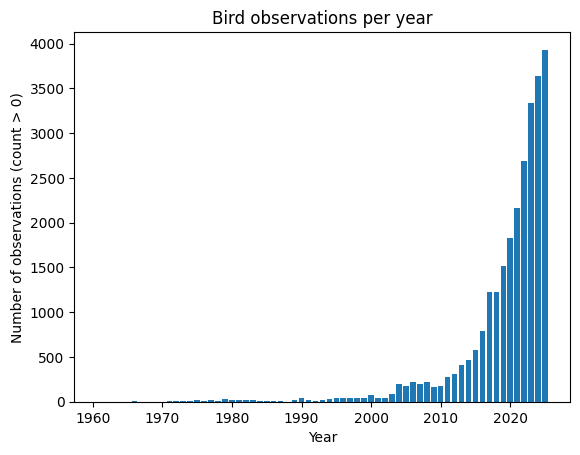

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_observations_per_year(df: pd.DataFrame) -> None:
    df = df.copy()

    # Ensure datetime
    df['OBSERVATION DATE'] = pd.to_datetime(df['OBSERVATION DATE'])

    # Keep only days with observations
    

    # Count number of observations per year
    yearly_counts = df['OBSERVATION DATE'].dt.year.value_counts().sort_index()

    # Plot
    plt.figure()
    plt.bar(yearly_counts.index, yearly_counts.values)
    plt.xlabel("Year")
    plt.ylabel("Number of observations (count > 0)")
    plt.title("Bird observations per year")
    plt.show()


histemp = historical()
#histemp
plot_observations_per_year(histemp)

In [2]:
import datetime
import requests
import pandas as pd
import hopsworks
import json
import re
import os
import warnings
warnings.filterwarnings("ignore")
from dotenv import load_dotenv
load_dotenv()

HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
project = hopsworks.login(api_key_value=HOPSWORKS_API_KEY, project="BirdUp")

fs = project.get_feature_store()

birding_clean_fg = fs.get_or_create_feature_group(
    name="birding_clean",
    version=1,
    description="Bird observations + weather + lags (clean Hudi FG)",
    primary_key=["region", "observation_date", "bird_type"],
    event_time="observation_date",
    hudi_precombine_key="ingested_at",
    online_enabled=False,
)


2026-01-06 12:48:15,425 INFO: Initializing external client
2026-01-06 12:48:15,426 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-01-06 12:48:17,029 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1327256


In [3]:
hist = df_functions.historical()
hist = df_functions.to_hopsworks_df(hist)

hist["ingested_at"] = pd.Timestamp.utcnow()

birding_clean_fg.insert(hist, wait=True)


Loaded cached weather for region: Skåne
Loaded cached weather for region: Blekinge
Loaded cached weather for region: Öland
Loaded cached weather for region: Halland
Loaded cached weather for region: Småland
Loaded cached weather for region: Gotland
Loaded cached weather for region: Västergötland
Loaded cached weather for region: Östergötland
Loaded cached weather for region: Bohuslän
Loaded cached weather for region: Dalsland
Loaded cached weather for region: Närke
Loaded cached weather for region: Södermanland
Loaded cached weather for region: Värmland
Loaded cached weather for region: Västmanland
Loaded cached weather for region: Uppland
Loaded cached weather for region: Gästrikland
Loaded cached weather for region: Dalarna
Loaded cached weather for region: Hälsingland
Loaded cached weather for region: Härjedalen
Loaded cached weather for region: Medelpad
Loaded cached weather for region: Ångermanland
Loaded cached weather for region: Jämtland
Loaded cached weather for region: Väster

Uploading Dataframe: 100.00% |██████████| Rows 273358/273358 | Elapsed Time: 01:07 | Remaining Time: 00:00


Launching job: birding_clean_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1327256/jobs/named/birding_clean_1_offline_fg_materialization/executions
2026-01-06 12:50:28,950 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2026-01-06 12:50:35,739 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


KeyboardInterrupt: 

In [5]:
from Features import df_functions
from hsfs.feature import Feature
import datetime
import requests
import pandas as pd
import hopsworks
import json
import re
import os
import warnings
warnings.filterwarnings("ignore")
from dotenv import load_dotenv
load_dotenv()

HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
project = hopsworks.login(api_key_value=HOPSWORKS_API_KEY, project="BirdUp")
fs = project.get_feature_store(name='birdup_featurestore')


def insert_daily_data():
    # retrive todays data: 
    birding_fg = fs.get_feature_group(name='birding',version=1,)
    daily_df = df_functions.daily()
    print(type(birding_fg.features[0]), birding_fg.features[0])

    features = birding_fg.features
    first = features[0]

    cols = [f.name for f in birding_fg.schema] 
    print("all strings:", all(isinstance(c, str) for c in cols))
    #print("hsfs:", hsfs.__version__)
    print("hopsworks:", hopsworks.__version__)

    print("types in cols:", sorted(set(type(c) for c in cols)))
    print("first 5 cols:", cols[:5])
    print("all strings:", all(isinstance(c, str) for c in cols))

    birding_fg.select(["region"]).read()



    df_prev = birding_fg.select(cols).read()

    daily_df = df_functions.to_hopsworks_df(daily_df)
    day_df_lag = df_functions.add_daily_lags_from_hopsworks_simple(daily_df, df_prev, k=5)
    birding_fg.insert(day_df_lag, wait=True)
    return
insert_daily_data()

2026-01-06 13:11:49,941 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-06 13:11:49,995 INFO: Initializing external client
2026-01-06 13:11:49,996 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-01-06 13:11:51,514 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1327256
WEATHER URL: https://archive-api.open-meteo.com/v1/archive?latitude=56.28473773910755&longitude=15.196045629685473&start_date=2026-01-06&end_date=2026-01-06&daily=temperature_2m_mean,precipitation_sum,wind_speed_10m_mean,weather_code&timezone=Europe%2FBerlin
REQUEST START: 2026-01-06 13:11:53.462917
REQUEST END: 2026-01-06 13:11:53.776254 status 200
WEATHER URL: https://archive-api.open-meteo.com/v1/archive?latitude=63.53636338957869&longitude=14.440236086450497&start_date=2026-01-06&end_date=2026-01-06&daily=temperature_2m_mean,precipitation_sum,wind_speed_10m_mean,weather_code&timezone=Europe%2FBerlin
REQUEST START: 2026-01-06 13:11:53.776887
REQUEST END: 2026-01-06 13:11:53.997563 status 200
WEATHER URL: https://archive-api.open-meteo.com/v1/archive?latitude=56.94792999019393&longitude=12.751296564028022&start_date=2026-01-06&end_date=2026-01-06&da

FeatureStoreException: Features are not compatible with Feature Group schema: 
 - weathercode (expected type: 'bigint', derived from input: 'double') has the wrong type.
Note that feature (or column) names are case insensitive and spaces are automatically replaced with underscores.

In [7]:
import hsfs, hopsworks, pyarrow
print("hsfs:", hsfs.__version__)
print("hopsworks:", hopsworks.__version__)
print("pyarrow:", pyarrow.__version__)
import great_expectations as ge
print(ge.__version__)


hsfs: 4.4.2
hopsworks: 4.4.2
pyarrow: 22.0.0
0.18.12
